In [175]:
import Postgres
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)

In [198]:
pgDN = Postgres.PostGres(servidor= '',
                               database= '',
                               usuario= '',
                               senha = '',
                               criptografia=False)

# BASE DE DADOS DE NOTiCIAS

## QUANTIDADE TOTAL DE NOTíCIAS
Capturadas entre os dias 12/04/2021 a 24/04/2021"

In [12]:
df = pgDN.retornaDataFramedeconsultaSQL("select \
                                        count(*) qtdNoticias \
                                    from \
                                        public.noticias t1 \
                                        inner join (select \
                                                      url, \
                                                      max(ctid) as id_record \
                                                    from public.noticias  \
                                                    group by url) as t2 \
                                        on (t1.ctid = t2.id_record)", 10)

In [13]:
df

,QTDNOTICIAS
0,2911


# QUANTIDADE TOTAL DE NOTíCIAS POR DATA DE PUBLICAÇÃO

In [14]:
df = pgDN.retornaDataFramedeconsultaSQL(" select \
                                            substring(publishedat,1,10) as dt_publish, \
                                            count(*) as qt_noticia\
                                        from \
                                            public.noticias t1 \
                                            inner join (select \
                                                          url, \
                                                          max(ctid) as id_record \
                                                        from public.noticias  \
                                                        group by url) as t2 \
                                            on (t1.ctid = t2.id_record) \
                                        group by substring(publishedat,1,10) \
                                        order by 1 ",100)

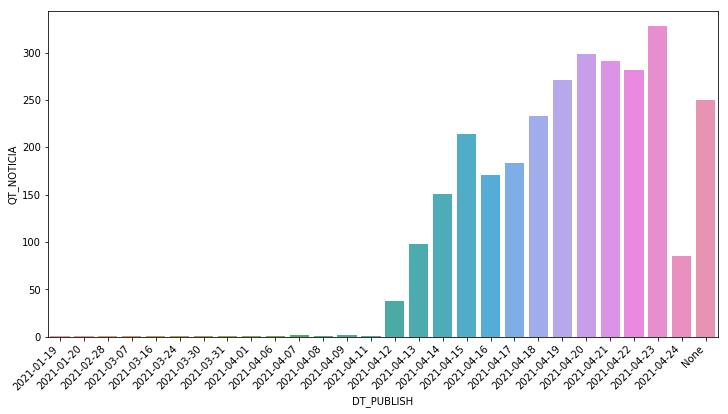

In [15]:
df['DT_PUBLISH']= df.loc[:,['DT_PUBLISH']].apply(lambda x: 'None' if x['DT_PUBLISH']==None else x['DT_PUBLISH'], axis=1)
fig, ax = plt.subplots(figsize=(12, 6))
by_dt_Publish = sns.barplot(x='DT_PUBLISH', y='QT_NOTICIA', data=df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

# QUANTIDADE DE NOTICIAS POR FONTE

In [16]:
df = pgDN.retornaDataFramedeconsultaSQL("select \
                                            source, \
                                            count(*) qt_noticia \
                                        from \
                                            public.noticias t1 \
                                            inner join (select \
                                                          url, \
                                                          max(ctid) as id_record \
                                                        from public.noticias   \
                                                        group by url) as t2 \
                                            on (t1.ctid = t2.id_record) \
                                        group by source \
                                        order by 1 ",100)

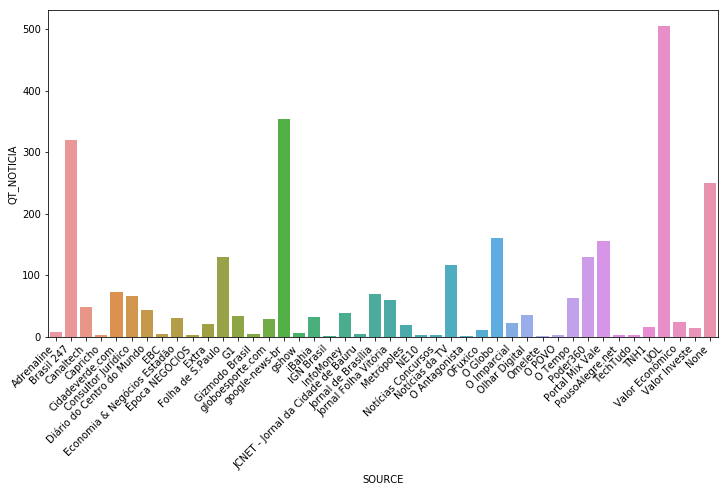

In [17]:
df['SOURCE']= df.loc[:,['SOURCE']].apply(lambda x: 'None' if x['SOURCE']==None else x['SOURCE'], axis=1)
fig, ax = plt.subplots(figsize=(12, 6))
by_dt_Publish = sns.barplot(x='SOURCE', y='QT_NOTICIA', data=df, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

# QUANTIDADE DE NOTICIAS POR CATEGORIA

As categoria foram extraídas da URL da noticia em tempo de captação. Geralmente, faz parte da composição da URL a seção que pertence a noticia sendo que a seção retrata a categoria. Por exemplo: economia, politicia, esporte, internacional entre outras. Há seções que são subdivididas, por exemplo: esporte, futebol, corinthians. A categoria é um array que possui a divisão principal e as subdivisões.

Estas categorias são bem genéricas, possui muito lixo e muitas das vezes a seção do sítio não corresponde ao que realmente é o assunto do texto. Por exemplo: um terremoto no Japão estará na seção Mundo.

Elas demandarão um bom trabalho para limpar e tentar manter uma palavra ou conjunto de palavras que classifique minimamente o assunto do texto para que possamos medir de alguma forma o resultado final do nosso trabalho.

Pensei em aplicar aqui no texto do título um algoritmo não supervisionado como o k-means ou o hieráquico para definir grupos de noticias. (o que pensa sobre isto?). Penso que são algoritmos simples e que devem gerar categorização satisfatória para compararmos com o resultado que será produzido pelas redes neurais sobre os textos. 

In [142]:
dfQtdCategoriaPorNoticia = pgDN.retornaDataFramedeconsultaSQL("select \
                                                                cardinality(categoria) categoria \
                                                                ,count(*) as qt_noticia\
                                                            from \
                                                                public.noticias t1 \
                                                                inner join (select \
                                                                              url, \
                                                                              max(ctid) as id_record \
                                                                            from public.noticias  \
                                                                            group by url, texto) as t2 \
                                                                on (t1.ctid = t2.id_record) \
                                                            group by cardinality(categoria) \
                                                            order by 1 desc",100)
dfCategoriaPorNoticia = pgDN.retornaDataFramedeconsultaSQL("select \
                                                                unnest(categoria) categoria, \
                                                                source, \
                                                                count(*) as qt_noticia\
                                                            from \
                                                                public.noticias t1 \
                                                                inner join (select \
                                                                              url, \
                                                                              max(ctid) as id_record \
                                                                            from public.noticias  \
                                                                            group by url, texto) as t2 \
                                                                on (t1.ctid = t2.id_record) \
                                                            group by unnest(categoria), source \
                                                            order by 2 desc ", 100)
dfCategoriaTamArray = pgDN.retornaDataFramedeconsultaSQL("select \
                                                                unnest(categoria) categoria, \
                                                                cardinality(categoria) as tam_Array, \
                                                                count(*) as qt_noticia\
                                                            from \
                                                                public.noticias t1 \
                                                                inner join (select \
                                                                              url, \
                                                                              max(ctid) as id_record \
                                                                            from public.noticias  \
                                                                            group by url, texto) as t2 \
                                                                on (t1.ctid = t2.id_record) \
                                                            group by unnest(categoria), cardinality(categoria) \
                                                            order by 3 desc ", 100)


## Quantidade de noticias pelo tamanho do array Categoria
Tem uma fatia bem grande sem categorias (azul). 

In [199]:
dfQtdCategoriaPorNoticia

,CATEGORIA,QT_NOTICIA
0,6,1
1,5,19
2,4,12
3,3,165
4,2,1187
5,1,2081
6,0,555


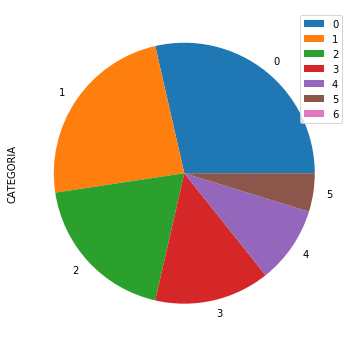

In [145]:

plot = dfQtdCategoriaPorNoticia.plot.pie(y='CATEGORIA',  figsize=(14, 6))

## CATEGORIAS MAIS FREQUENTES
Vou efetuar uma limpeza tirando as que não possuem semântica: noticia, redação, blog, números, entre outras. Como são poucas fica fácil verificar manualmente.

In [155]:
dfCategoriaPorNoticiaAgr = dfCategoriaPorNoticia.groupby(['CATEGORIA']).sum().reset_index().sort_values(['QT_NOTICIA'], ascending=False).reset_index()

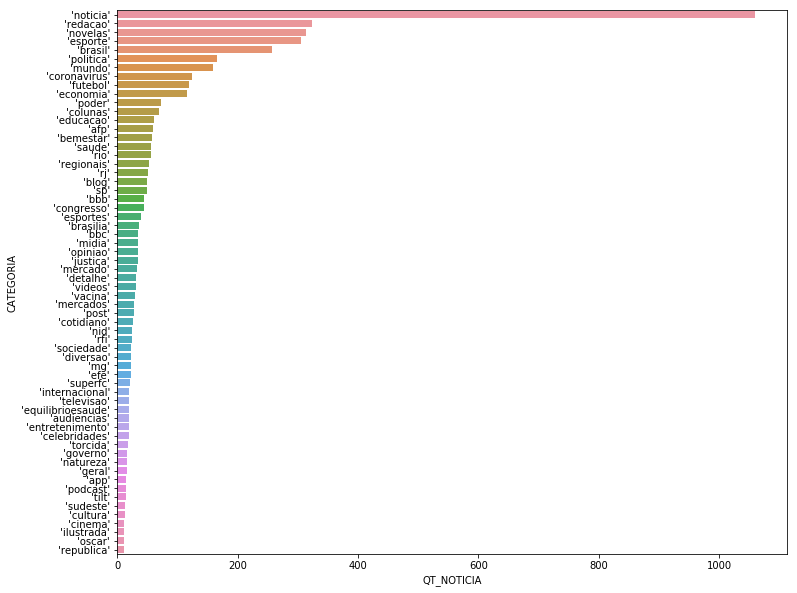

In [157]:
fig, ax = plt.subplots(figsize=(12, 10))
df = dfCategoriaPorNoticiaAgr[dfCategoriaPorNoticiaAgr['QT_NOTICIA']>10]
by_Categoria = sns.barplot(y='CATEGORIA', x='QT_NOTICIA', data=df, ax=ax)


plt.show()

### Por quantidade de categorias no Array

In [160]:
dfTamArray = dfCategoriaTamArray[dfCategoriaTamArray['TAM_ARRAY']==1].reset_index()
print('30 Categorias menos frequentes para Array de tamanho 1: \n', dfTamArray.tail(30))
print('30 Categorias mais frequentes para Array de tamanho 1: \n',dfTamArray.head(30))

30 Categorias menos frequentes para Array de tamanho 1: 
      index                                          CATEGORIA  TAM_ARRAY  \
139     47                                           '345161'          1   
140     50                                           '345284'          1   
141     52                                           '344947'          1   
142     53                                          'reviews'          1   
143     54                                           '345057'          1   
144     55  '13o-salario-nao-aparece-no-extrato-do-inss-pa...          1   
145     57                                           '345124'          1   
146     58                                           '345407'          1   
147     59                                           '345315'          1   
148     60                                         'software'          1   
149     62                                           '345555'          1   
150     63                    

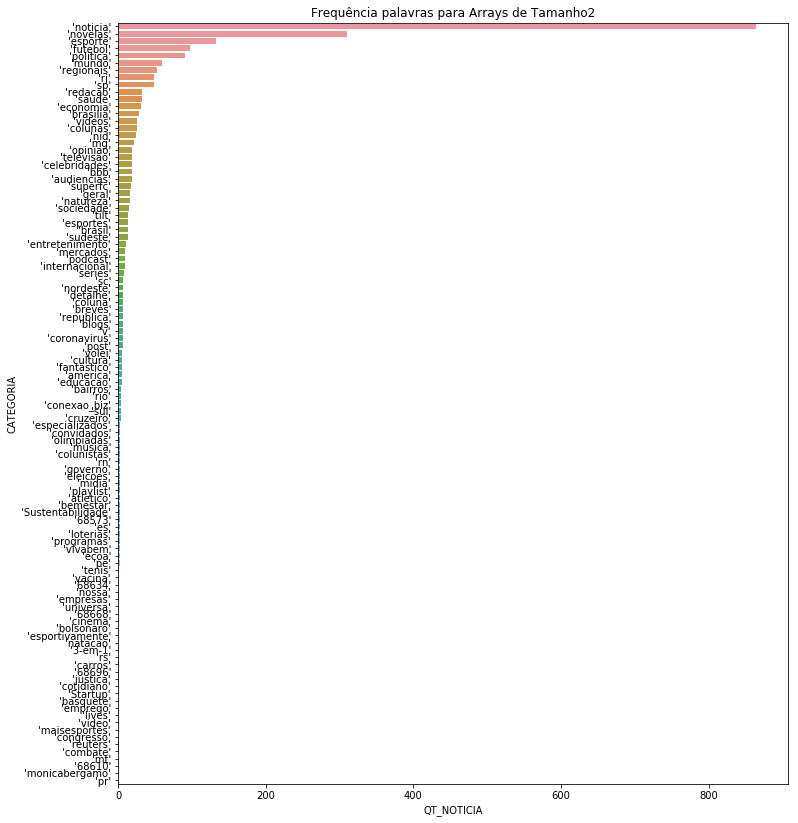

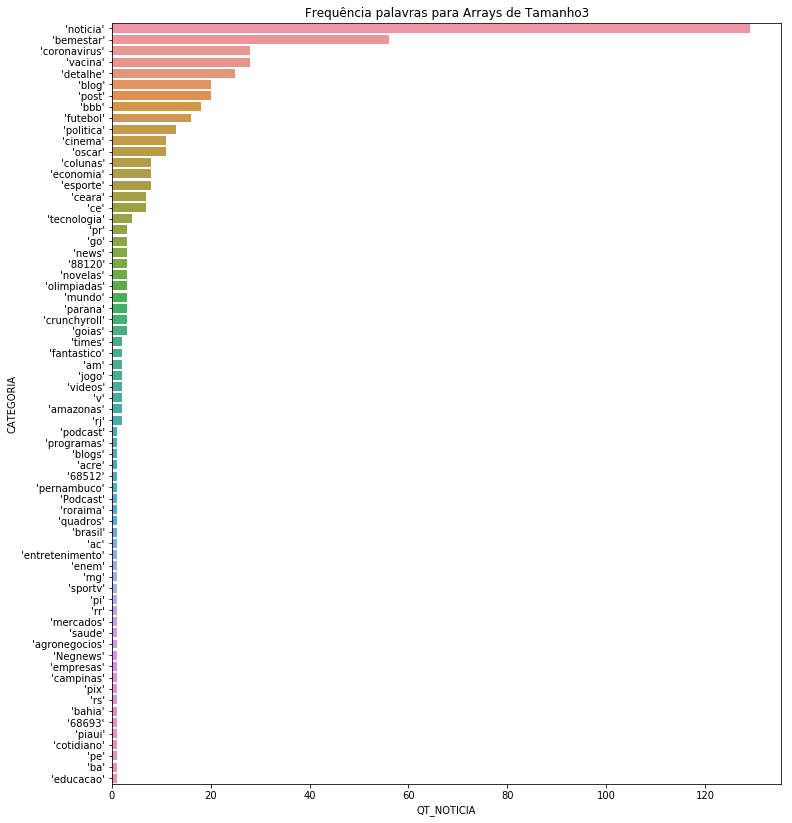

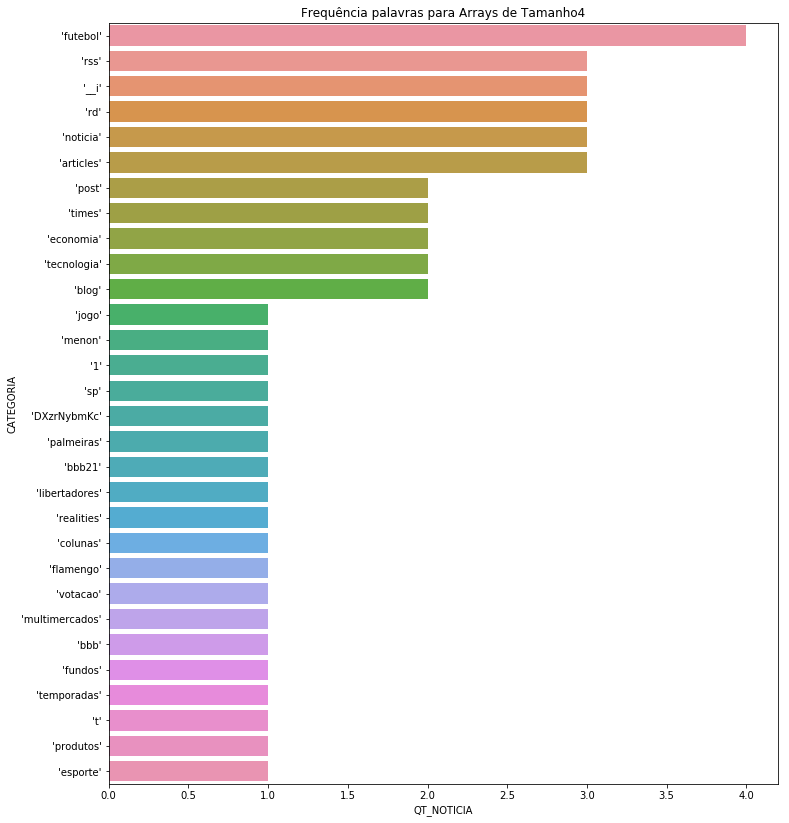

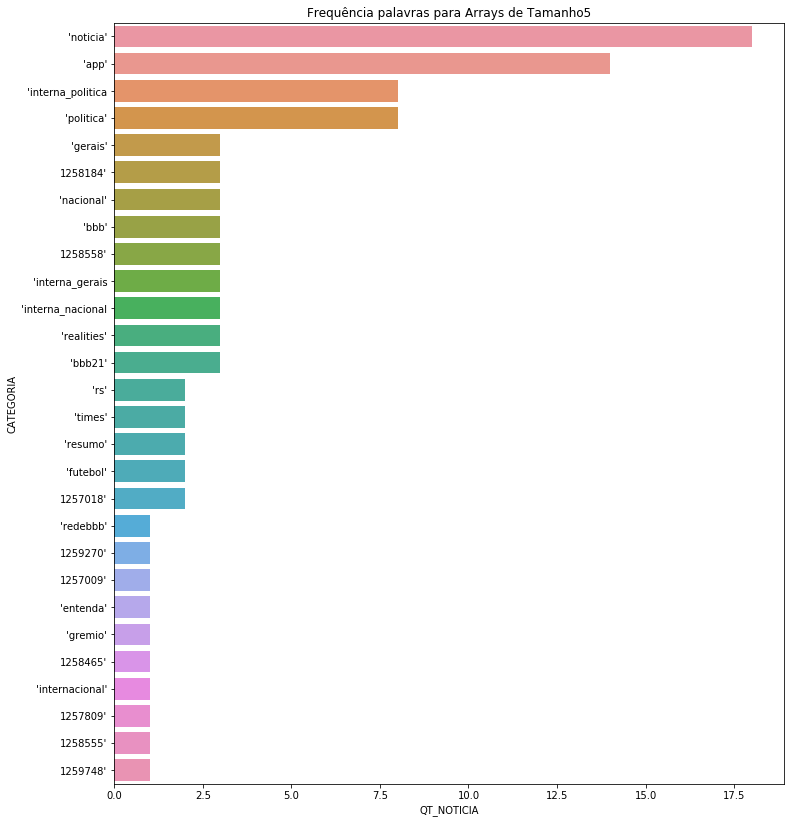

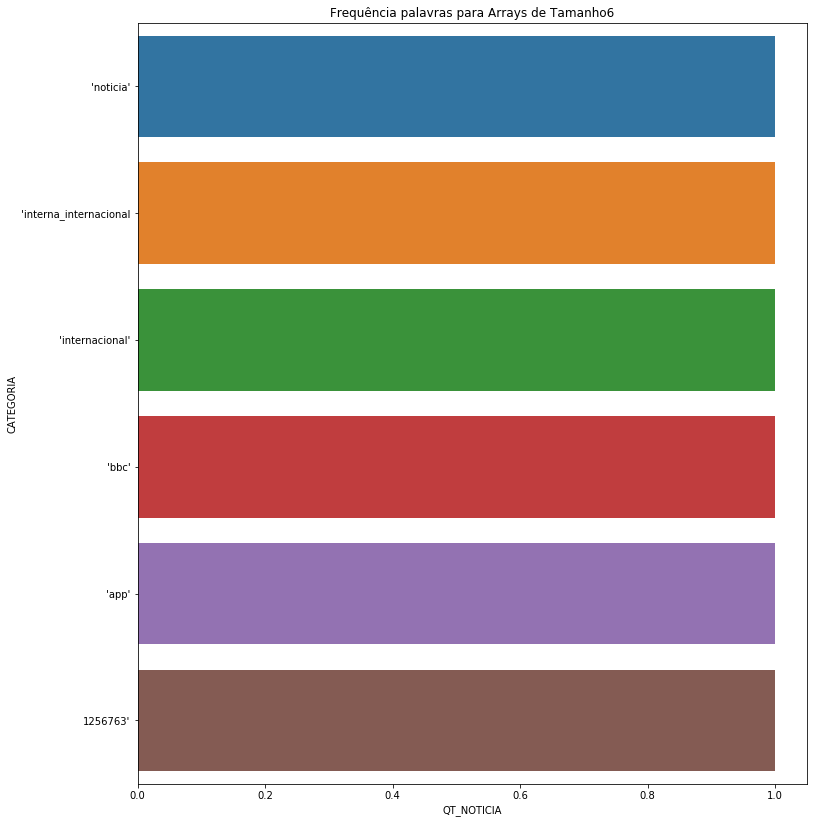

In [99]:
df = dfCategoriaTamArray[dfCategoriaTamArray['TAM_ARRAY']>1]
for i in sorted(df['TAM_ARRAY'].unique()):
    fig, ax = plt.subplots(figsize=(12, 14))
    dfTamArray = df[df['TAM_ARRAY']==i]
    by_Categoria = sns.barplot(y='CATEGORIA', x='QT_NOTICIA', data=dfTamArray, ax=ax)
    ax.set(title="Frequência palavras para Arrays de Tamanho" + str(i))
    plt.show()
    


In [165]:
dfCategoriaPorNoticiaAgr_Uol = dfCategoriaPorNoticia[dfCategoriaPorNoticia['SOURCE']=='UOL']\
                            .groupby(['CATEGORIA']) \
                            .sum().reset_index() \
                            .sort_values(['QT_NOTICIA'], ascending=False).reset_index()
dfCategoriaPorNoticiaAgr_Uol

,index,CATEGORIA,QT_NOTICIA
0,19,'redacao',316
1,11,'esporte',151
2,12,'futebol',91
3,0,'afp',59
4,6,'colunas',58
5,3,'bbc',34
6,18,'politica',26
7,28,'videos',25
8,21,'rfi',24
9,10,'efe',23


In [166]:
dfCategoriaPorNoticiaAgr_Uol = dfCategoriaPorNoticia[dfCategoriaPorNoticia['SOURCE']=='google-news-br']\
                            .groupby(['CATEGORIA']) \
                            .sum().reset_index() \
                            .sort_values(['QT_NOTICIA'], ascending=False).reset_index()
dfCategoriaPorNoticiaAgr_Uol

,index,CATEGORIA,QT_NOTICIA
0,51,'noticia',164
1,56,'politica',45
2,12,'brasil',34
3,66,'rj',23
4,65,'rio',21
5,72,'sp',19
6,47,'mundo',19
7,44,'mg',16
8,21,'coronavirus',16
9,5,'app',15


In [167]:
dfCategoriaPorNoticiaAgr_Uol = dfCategoriaPorNoticia[dfCategoriaPorNoticia['SOURCE']=='Brasil 247']\
                            .groupby(['CATEGORIA']) \
                            .sum().reset_index() \
                            .sort_values(['QT_NOTICIA'], ascending=False).reset_index()
dfCategoriaPorNoticiaAgr_Uol

,index,CATEGORIA,QT_NOTICIA
0,1,'brasil',134
1,12,'regionais',53
2,11,'poder',35
3,2,'brasilia',29
4,0,'blog',27
5,8,'midia',26
6,9,'mundo',20
7,3,'coronavirus',18
8,13,'sudeste',13
9,5,'economia',10


# QUANTIDADE DE NOTíCIAS COM ALGUM TEXTO DE NOTíCIA
Algumas url não permitem o acesso ao texto da noticia. Isto acontece por vários motivos, o princípal é que o conteúdo é privado e deve haver um usuário e senha para obtê-lo (tem que assinar o portal de notícia) para obter o texto.

In [190]:
df = pgDN.retornaDataFramedeconsultaSQL("select \
                                            case when texto = 'NA' then \
                                                    'SEM TEXTO' \
                                                 else 'COM TEXTO' \
                                            end TEM_TEXTO, \
                                            case when title is not null then \
                                                    'COM TITULO' \
                                                 else 'SEM TITULO' \
                                            end TEM_TITULO, \
                                            case when description is not null then \
                                                    'COM RESUMO' \
                                                 else 'SEM RESUMO' \
                                            end TEM_DESCRIPTION, \
                                            source, \
                                            count(*) qt_noticia \
                                        from \
                                            public.noticias t1 \
                                            inner join (select \
                                                          url, \
                                                          max(ctid) as id_record \
                                                        from public.noticias   \
                                                        group by url) as t2 \
                                            on (t1.ctid = t2.id_record) \
                                        group by  \
                                            case when texto = 'NA' then \
                                                    'SEM TEXTO' \
                                                 else 'COM TEXTO' \
                                            end, \
                                            case when title is not null then \
                                                    'COM TITULO' \
                                                 else 'SEM TITULO' \
                                            end, \
                                            case when description is not null then \
                                                    'COM RESUMO' \
                                                 else 'SEM RESUMO' \
                                            end, \
                                            source\
                                        order by 1",100 )

dfTexto = dfTexto = pgDN.retornaDataFramedeconsultaSQL("select t1.* from \
                                              public.noticias t1 \
                                              inner join (select \
                                                          url, \
                                                          max(ctid) as id_record \
                                                        from public.noticias   \
                                                        group by url) as t2 \
                                              on (t1.ctid = t2.id_record) ", 10)



In [125]:
dfGrp = df.groupby(['TEM_TEXTO','TEM_TITULO']).sum()
dfGrp

,,QT_NOTICIA
TEM_TEXTO,TEM_TITULO,
COM TEXTO,COM TITULO,2601
SEM TEXTO,COM TITULO,362


Do UOL

In [126]:
dfGrp = df[df['SOURCE']=='UOL'].groupby(['TEM_TEXTO','TEM_TITULO']).sum()
dfGrp

,,QT_NOTICIA
TEM_TEXTO,TEM_TITULO,
COM TEXTO,COM TITULO,512
SEM TEXTO,COM TITULO,5


DO GOOGLE-NEWS-BR

In [127]:
dfGrp = df[df['SOURCE']=='google-news-br'].groupby(['TEM_TEXTO','TEM_TITULO']).sum()
dfGrp

,,QT_NOTICIA
TEM_TEXTO,TEM_TITULO,
COM TEXTO,COM TITULO,323
SEM TEXTO,COM TITULO,35


DO BRASIL 247

In [130]:
dfGrp = df[df['SOURCE']=='Brasil 247'].groupby(['TEM_TEXTO','TEM_TITULO']).sum()
dfGrp

,,QT_NOTICIA
TEM_TEXTO,TEM_TITULO,
COM TEXTO,COM TITULO,327
SEM TEXTO,COM TITULO,3


In [196]:
dfTexto[dfTexto['SOURCE']=='UOL'].tail(30)

TITLE  \
9  Caio confessa ter se magoado com atitudes de Viih Tube no jogo                                         
0  Festa top 7 é marcada por choro, climão e cachorrada de Gil                                            
3  Covid-19: é possível adaptar as medidas de restrição às novas cepas?                                   
9  comentarista da ESPN publica nude por acidente                                                         
1  Caio diz que perdeu quase 15kg no reality por causa da saudade                                         
2  Fiuk reclama de músicas de criança na festa                                                            
3  Morte por covid após vacina: o que explica internações e casos raros de óbito mesmo após duas doses?   
4  Brasileira que desenhou cenários do filme "Mank" concorre ao Oscar de Melhor Design de Produção        
6  Aos risos, Bolsonaro desafia governadores com Exército e CPI com cloroquina                            
9  Sem máscara, Bolsonaro gera aglomeração em vista a feira de Ceilândia                                  
7  Marco Aurélio envia ao plenário ação que aponta omissão de Bolsonaro na pandemia                       
8  O fim da Lava Jato e o patético Barroso                                                                
9  como está a seleção brasileira?                                                                        
2  País da Copa tem falcões de R$ 1 milhão e camelos montados por robôs                                   
3  Globo tem um ano para se reconciliar com Conmebol por volta da Libertadores                            
4  Juca: Palmeiras precisa detectar logo por que acontecem esses apagões                                  
6  Fabíola Andrade é a nova comentarista de futebol da emissora                                           
5  Edina Alves vai representar arbitragem brasileira em campo                                             
6  Levy Fidelix morre aos 69 anos em São Paulo                                                            
7  Gil diz que não pediria mutirão para Juliette em paredão                                               
8  Viih diz que está preparada para o paredão                                                             
0  Brothers brindam os últimos 10 dias de reality                                                         
3  A Vida da Gente: resumo do capítulo de hoje                                                            
4  resumo do capítulo de hoje                                                                             
5  As coisas que faltam na era da abundância                                                              
1  Com equipe alternativa, Santos perde para Novorizontino                                                
2  Após suspensão, EUA retomam uso da vacina da Johnson & Johnson                                         
3  LGPD e Defesa da Concorrência: o caso Facebook                                                         
4  'Filhos de Chernobyl': o que diz primeiro estudo de descendentes dos atingidos pelo acidente nuclear   
5  Lei da telemedicina completa um ano ainda com desafios                                                 

                                                                                                                                                                                                                                                       DESCRIPTION  \
9  BBB 21 no UOL - Acompanhe toda a cobertura: participantes, enquetes, paredões, provas, opiniões de colunistas, festas e casais do Big Brother Brasil de 2021.                                                                                                     
0  BBB 21 no UOL - Acompanhe toda a cobertura: participantes, enquetes, paredões, provas, opiniões de colunistas, festas e casais do Big Brother Brasil de 2021.                                                                                                

In [197]:
dfTexto[dfTexto['SOURCE']=='google-news-br'].tail(30)

TITLE  \
1  Irmão de Wilson Witzel é preso por posse ilegal de arma durante operação em Jundiaí                                                    
2  Fiocruz alerta para "gap" na entrega de vacinas ao Ministério da Saúde                                                                 
3  Entenda a briga entre Salles e Anitta por conta de questões ambientais                                                                 
5  Caso Henry: novo laudo aponta lesões no rosto causadas por unha                                                                        
0  IFA que chegará no sábado garante vacinas até 2 de junho, diz Fiocruz                                                                  
5  Comentários de Bolsonaro em cúpula 'surpreenderam', diz enviado para o clima de Biden, que questiona se promessas serão cumpridas      
6  Brasil registra mais 2.027 vítimas da covid-19 e total vai a 383,5 mil                                                                 
7  Fiocruz prevê hiato de dois meses na entrega de vacinas contra Covid                                                                   
3  Número de policiais mortos com Covid-19 é mais que o dobro dos que foram assassinados nas ruas em 2020                                 
4  Após impasse com o Congresso, governo sanciona com vetos do Orçamento de 2021                                                          
5  Ministro da Educação diz que 'falha de TI' gerou ausência de 1,4 milhão de matrículas para cálculo do repasse de verbas do Fundeb      
6  Plenário do STF forma maioria para manter suspeição de Moro para julgar Lula                                                           
7  Apesar de Bolsonaro falar em 'fortalecimento da fiscalização', nova norma dificulta aplicação de multas ambientais - BBC News Brasil   
9  Covid-19: vacinação dos grupos prioritários terminará em setembro, prevê Ministério da Saúde                                           
7  Bolsonaro ignora críticas e insiste em nomear Pazuello para cargo no Planalto                                                          
8  Butantan envia à Anvisa documentação completa para autorização de testes da ButanVac                                                   
9  Jairinho segue em isolamento em Bangu após sair para consulta psiquiátrica                                                             
0  Covid: SP tem queda de casos, mortes e internações pela 1ª vez em 2 meses                                                              
1  Governo diz que Orçamento não prevê recursos para o Censo e que pesquisa não ocorrerá em 2021                                          
2  Pesquisa mostra que eleitor ainda não tem alternativa a Bolsonaro e Lula na eleição de 2022                                            
3  'Chega de mentiras': Casagrande faz textão em rede social e detona fala de Bolsonaro em Cúpula do Clima - ISTOÉ Independente           
4  Estado de SP envia protocolo do estudo clínico da Butanvac à Anvisa | Governo do Estado de São Paulo                                   
5  Julgamento de suspeição de Moro tem embate sobre legado da "lava jato"                                                                 
2  YouTube derruba mais 4 vídeos onde Bolsonaro fala de remédios sem eficácia contra Covid, mas não suspende canal                        
7  Morre Levy Fidelix, fundador do PRTB, aos 69 anos                                                                                      
8  Milicianos ligaram para "Jair" da "Casa de vidro" após morte de Adriano da Nóbrega, diz site | Revista Fórum                           
9  Museus, parques, restaurantes, academias e salões de beleza reabrem a partir deste sábado em SP                                        
8  Bolsonaro e Mourão lamentam morte de Levy Fidelix; veja repercussão                                                                    
9  Fase de transição: Ribeirão Preto e Franca reabrem academias, salões e restaurantes; veja horári